# Gas Phase UED Processing Code
Written by LFH in Oct 2023. 
Adapted from code provided by Yusong Liu and Caidan Moore

## Standard Steps

1. __Import all images__
    * Function called `gued.get_image_details` is used to load in all .tif files in the specified folder of interest. The function returns the images as a 3D data array, a 1D array of stage positions, file order, and total counts per image.

2. __Average Based on Stage Positions__
    * Group all images based on the stage positions in order to speed up data processing steps for large data sets

3. __Find Centers__
    * Find diffraction center for all images using the function called `gued.find_centers_pool` which runs the `find_center_alg` function in parallel

4. __Reject images with bad total counts__
    * Function called `gued.remove_counts` loads in the returns from `gued.get_image_details` and removes any images based on their total counts then returns the inputs with bad images removed.

5. __Subtract background__
    * The function called `gued.remove_background_pool` takes in a 3D array containing all image files and runs the hidden function `_remove_background` which creates a background image based on the corners of the original image. Then can either return the interpolated backgrounds or the cleaned data.
    * In cases where background images are taken as part of the experiment, use the `subtract_background` function with the data array and an average background image.

6. __Remove outlier instances of identical pixels__
    * This is generally referred to as removing x-ray hits or hot pixels. When working with large data sets, use the `gued.remove_xrays_pool` function. This function takes the 3D data array and runs the hidden function `_remove_xrays` in parallel. The function looks for instances of outlier pixels with respect to the average pixel value for all data. Returns the original data array with hot pixel values replaced with `np.nan`.

7. __Mask detector hole__
    * The function `gued.apply_mask` uses the `gued.mask_generator_alg` function to create a mask of `np.nan` values based on center and set radius. Returns masked data. Has the capability to apply multiple masks.

8. __Calculate diffraction center__
    * The function `gued.find_center_pool` runs the function `gued.find_center_alg` in parallel to find the center of all images. The pool function speeds up the process significantly but with small data sets can run `gued.find_center_alg` directly.

9. __Remove radial outliers__
    * The function `gued.remove_radial_outliers_pool` uses the hidden function `gued._preprocess_radial_data` which converts the data to polar coordinates, creates an interpolated average image from radial averages, then looks for instances of radial outliers and replaces them with `np.nan`.
    * This is by far the most time-consuming part of data processing. __Only do this with small data sets (i.e., after stage averaging) unless you're willing to spend a long time processing data.__ Takes 10 minutes per 100 images running in parallel.

10. __Apply median filter__
    * The function `gued.median_filter` applies a median filter to the data. Must replace `np.nan` values with radial average so this function is done in concert with the radial outlier removal (need to finalize).

11. __Retrieve Azimuthal Average__
    * The function `gued.azimuthal_average` takes the 3D data array and returns the azimuthal average for each data set.


### To Do

* Make flexible by using consistent names for things
* Create larger package instead of notebook

## Import Necessary Functions

In [2]:
# Standard Packages
import numpy as np
from math import exp, sqrt, floor
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
from datetime import date
import scipy.interpolate as interp
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

#%matplotlib inline
from skimage import util


#ff stuff
from multiprocessing.dummy import Pool as ThreadPool


# new code 
import gued

NameError: name 'STD_FACTOR' is not defined

## Global Variable Usage
The package gued relies on a few global variables which should be optimized for each experiment. The global variables are stored in gued_globals.py and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [ ]:
%%writefile gued_globals.py
### Global Variables for entire code
CENTER_GUESS = (460, 460)
RADIUS_GUESS = 40
DISK_RADIUS = 3
CORNER_RADIUS = 20
CHECK_NUMBER = 50

MASK_CENTER = [475, 475]
MASK_RADIUS = 45
ADDED_MASK = [[440, 435, 30]]
SEPARATORS = ['-', '_']

STD_FACTOR = 3
MAX_PROCS = 6


Overwriting gued_globals.py


## Define Functions

### Save Notebook Session

In [2]:
def save_session(file_name):
    today = date.today()
    dill.dump_session(f'{file_name}_{today}.db')
    print("Session saved to ", file_name)

def load_session(file_name):
    file_name = file_name + '.db'
    dill.load_session(f'{file_name}.db')
    print(file_name, " session loaded")

### Cleaning Functions

In [3]:
def gaussian_filter_2d(data_array, sig=1):
    """Applies the scipy.ndimage.gaussian_filter() on the 2D data array. Returns filtered images"""
    gf_filtered = gaussian_filter(data_array, sig)
    return gf_filtered
    
def fit_high_s(data_array, x_vals, s_range, return_baseline=False):
    if len(data_array.shape) == 2:
        corrected_data = []
        baseline = []
        for i in range(len(data_array)):
            temp_data = data_array[i]
            coeff = np.polyfit(x_vals[s_range], temp_data[s_range], 2)
            line = np.polyval(coeff, x_vals[s_range])
            baseline.append(line)
            data_array[i, s_range] = temp_data[s_range] - line
            corrected_data.append(data_array[i])
            
    elif len(data_array.shape) == 1:
        coeff = np.polyfit(x_vals[s_range], data_array[s_range], 1)
        baseline = np.polyval(coeff, x_vals)
        
        corrected_data = data_array - baseline
    else:
        print("Data Array must be 1D or 2D array")
    
    corrected_data= np.array(corrected_data)
    
    if return_baseline == True:
        return corrected_data, baseline
    else:
        return corrected_data

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [5]:
dataPath = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\'
runPath = "\\*\\*\\*\\ANDOR1_*.tif"


bkg_path = '/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180823\Run\\*\*\*\ANDOR1_*.tif
/work/centurion/shared/UED_data/FY18_o-nitrophenol/20180823/Background/*/*/ANDOR1_*.tif
1998
0


### Reading in All Data and Getting Total Counts -- Lauren's Version

Loading diffraction signal


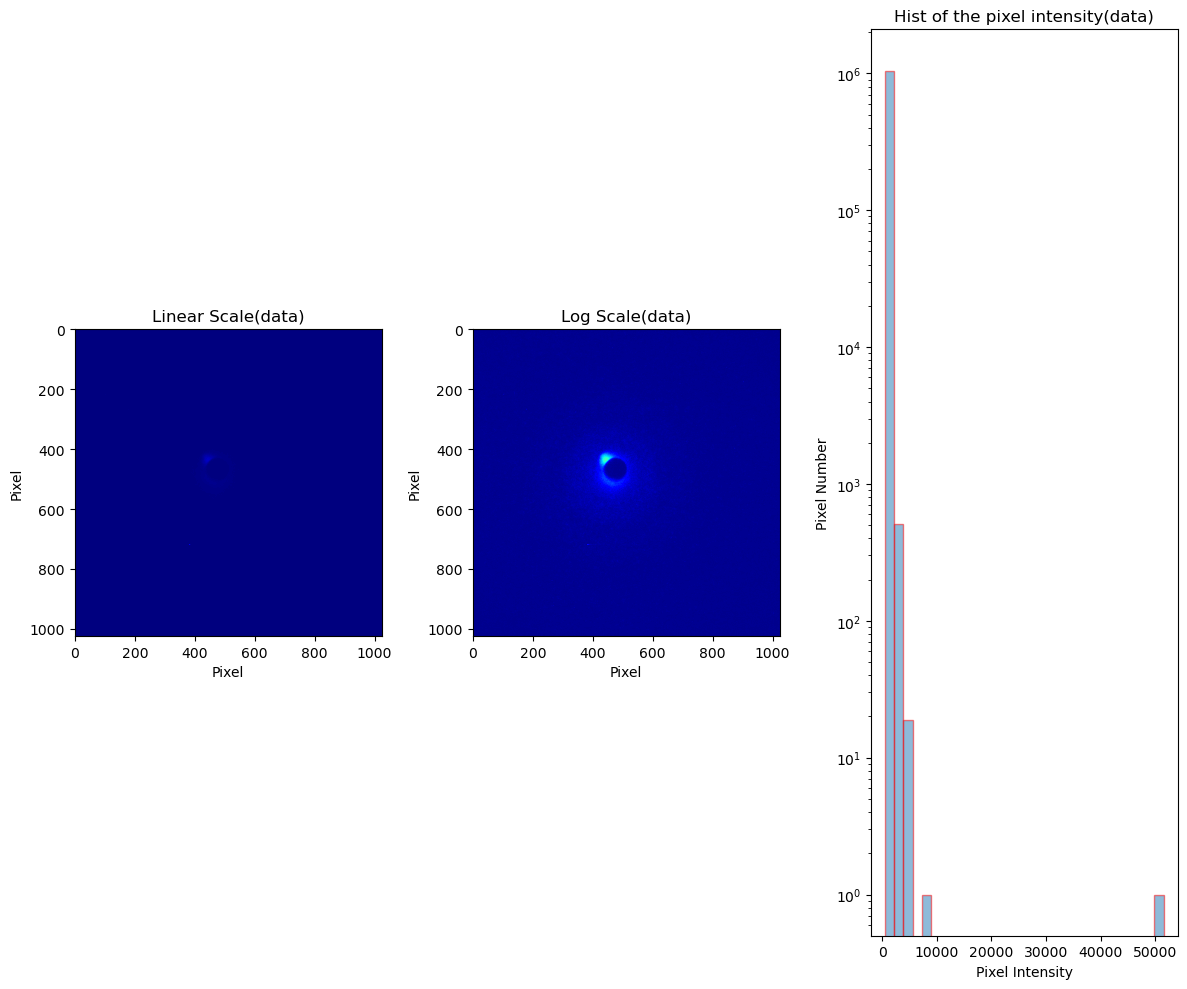

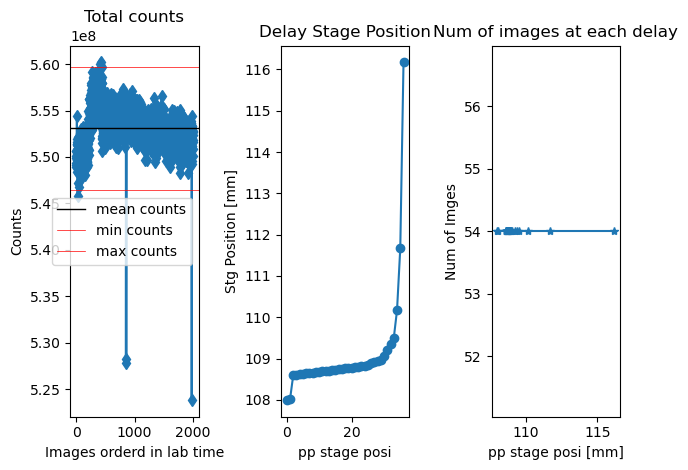

In [6]:
print('Loading diffraction signal');
data_array, stage_positions, file_numbers, counts = gued.get_image_details(files[:], plot=True, sort=True)

counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position


## Filtering Out Bad Shots Based on Total Counts

1892
106  number of files removed from  1998  initial files


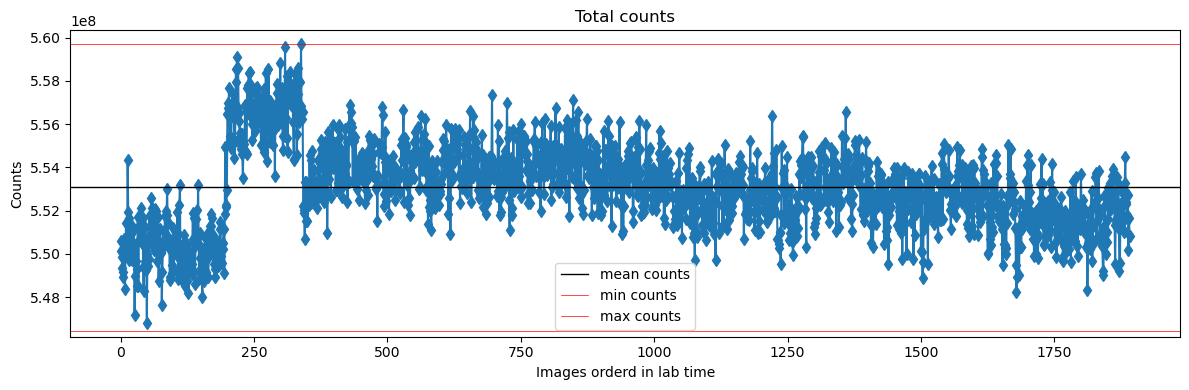

In [18]:
good_data, good_stage, good_order, good_counts = gued.remove_counts(data_array, stage_positions, 
                                                               file_numbers, counts, added_range=[[200, 300]], plot=True)

## Averaging Based on Delay Position

In [19]:
good_data.shape

(1892, 1024, 1024)

In [20]:
%%time
stage_len = len(uni_stage);               #  Number of delays
stage_ave = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images
stage_ave_mk = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images with mask

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = good_data[np.where(good_stage==uni_stage[i])[0]];
    stage_ave[i] = np.nanmean(stage_data,axis=0); # no subtracting background

    


Averaging data at stage posi # 0, 108.0 mm
Averaging data at stage posi # 5, 108.63 mm
Averaging data at stage posi # 10, 108.68 mm
Averaging data at stage posi # 15, 108.73 mm
Averaging data at stage posi # 20, 108.78 mm
Averaging data at stage posi # 25, 108.85 mm
Averaging data at stage posi # 30, 109.05 mm
Averaging data at stage posi # 35, 111.67 mm
CPU times: total: 3.42 s
Wall time: 11.7 s


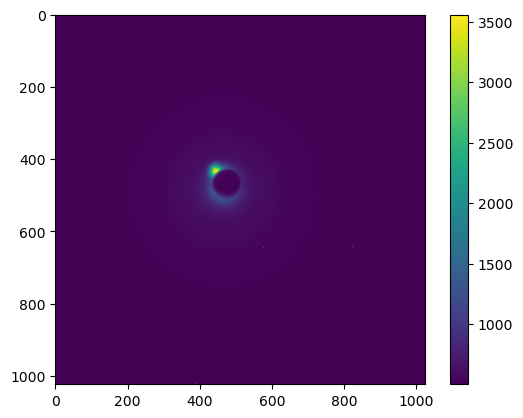

In [21]:
plt.figure()
plt.imshow(stage_ave[0])
plt.colorbar()
plt.show()

del good_data, good_stage, good_order

## Finding Diffraction Center -- Before Averaging Cuong's Code

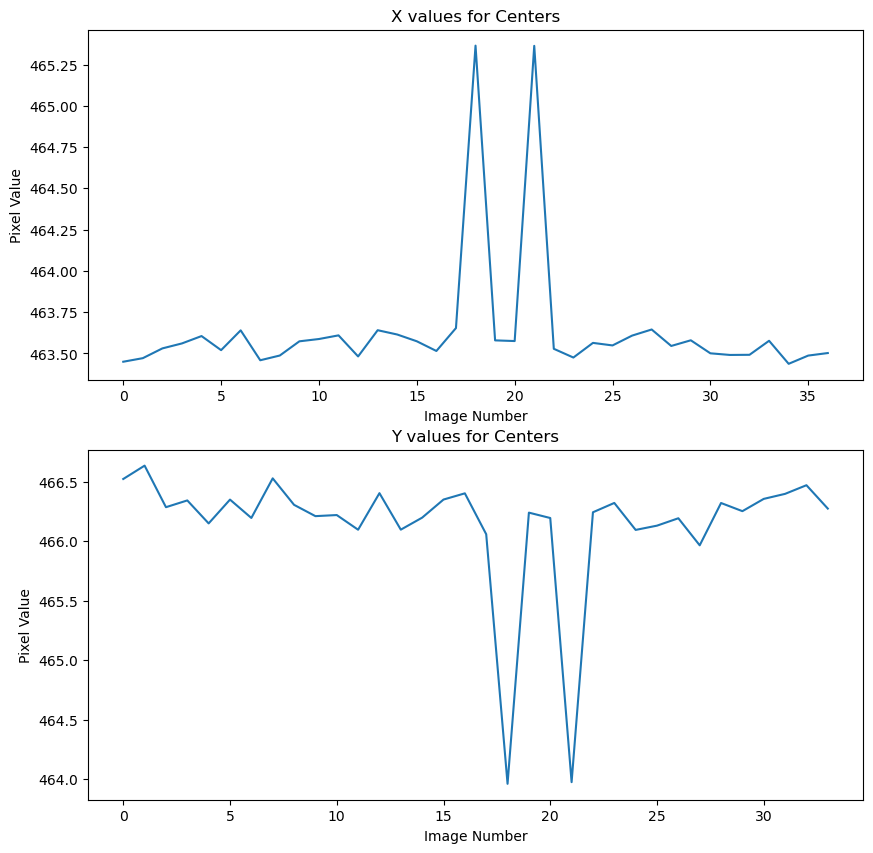

Averaged ctr is (463.64452939359853, 466.1700545549839)
Percentage of images where the center finding failed (i.e., found the guess value): 0.0


In [23]:
# only works when done before other steps...
center_x, center_y = gued.find_center_pool(stage_ave, plot=True)

## Generate Background Based on Corners

<Figure size 1200x400 with 0 Axes>

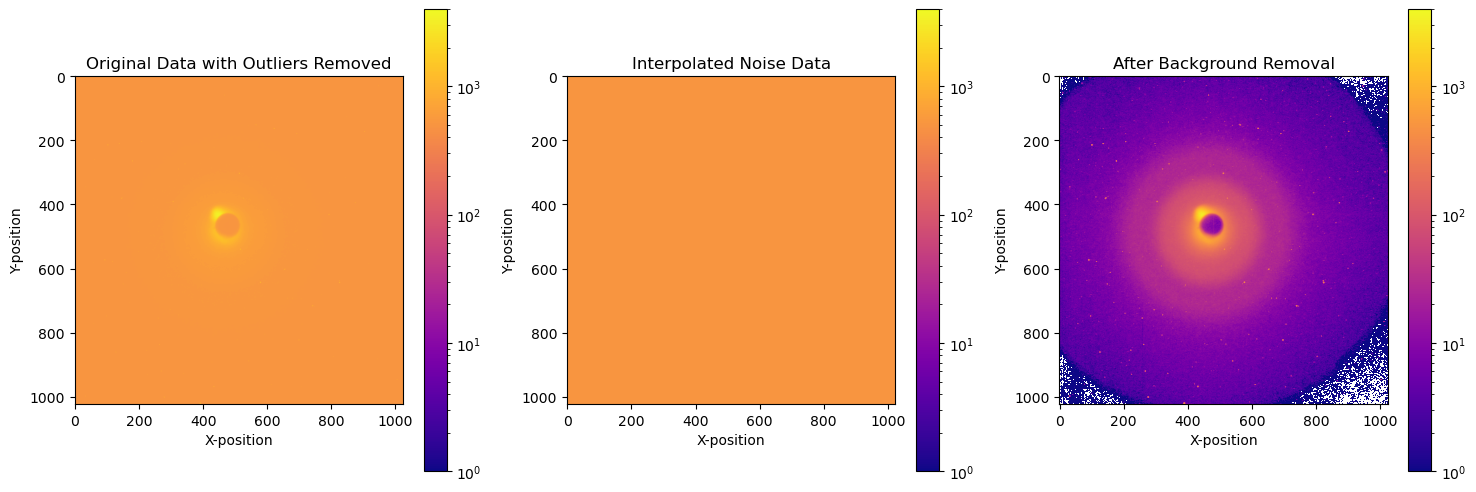

In [24]:
clean_data = gued.remove_background_pool(stage_ave, plot=True)

## Removing Hot Pixels -- Runs in Parallel

Removing hot pixels from all data


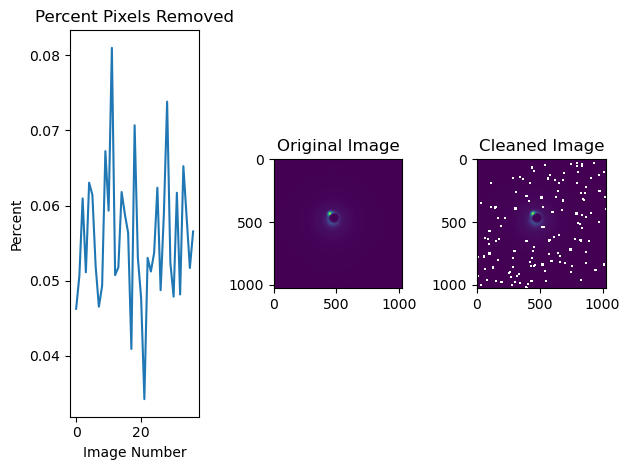

In [25]:
new_data = gued.remove_xrays_pool(clean_data, plot=True)

## Masking Beam Block

c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\Coding Lab Notebook\GUED_Analysis\GUED.py:983: RuntimeWarning: Mean of empty slice
  


(37, 1024, 1024)


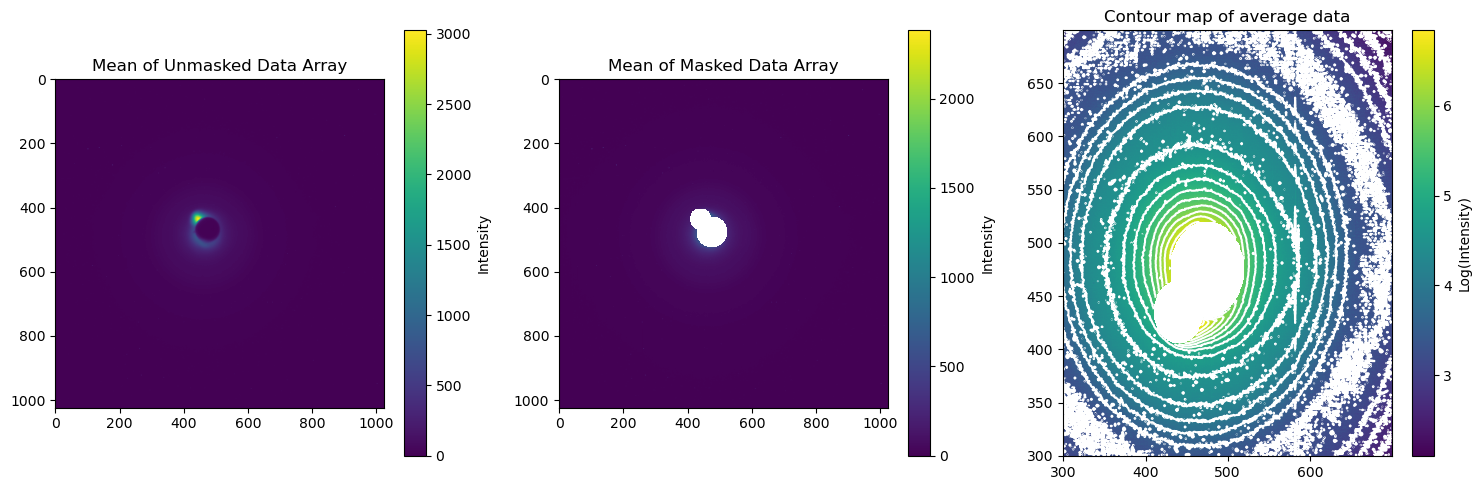

In [26]:
masked_data = gued.apply_mask(new_data, plot=True)

## Remove Radial Outliers

Done cleaning image 0
Done cleaning image 5
Done cleaning image 10
Done cleaning image 15
Done cleaning image 20
Done cleaning image 25
Done cleaning image 30
Done cleaning image 35


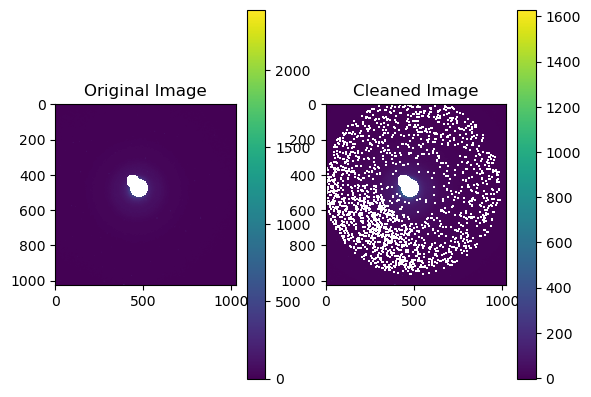

In [27]:
center = [489, 464]
cleaned_data = []

for i in range(len(masked_data)):
    cleaned = gued.cleaning_2d_data(masked_data[i], center)
    cleaned_data.append(cleaned)
    if i%5 == 0:
        print(f"Done cleaning image {i}")

cleaned_data = np.array(cleaned_data)


plt.figure()
plt.subplot(1,2,1)
plt.imshow(masked_data[0])
plt.colorbar()
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(cleaned_data[0])
plt.colorbar()
plt.title("Cleaned Image")
plt.show()

## Clean After Averaging

Cleaning all data with concurrent.futures.ProcessPoolExecutor
(37, 1024, 1024)
Finished cleaning!!


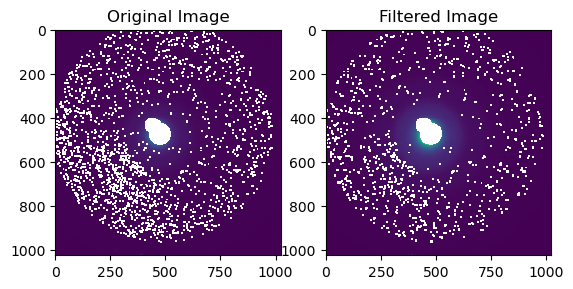

In [28]:

clean_data = gued.median_filter_pool(cleaned_data)
clean_data = np.array(clean_data)
counts_clean = gued._get_counts(clean_data)

counts_clean_mean = np.mean(counts_clean)
counts_clean_std = np.std(counts_clean)

## Finding Diffraction Center -- After Processing

Right now it is only worthwhile to run this on the stage averaged data as it takes a very long time. Ultimately will try to get working in parallel in order to find the center of each individual image. __Note:__ occasionally it returns a 0, 0 value for the centers. The average of all non-zero values are taken and then each zero is replaced with the average center. Test this vs lab time.

In [29]:
stage_ave = clean_data
stage_ave.shape

(37, 1024, 1024)

In [30]:
%%time

x_centers = []
y_centers = []
for i in range(len(stage_ave)):
    center = gued.find_beam_center(stage_ave[i],center=[400,400],r=200)
    x_centers.append(center[0])
    y_centers.append(center[1])
    if i%1 == 0:
        print('Found center of ' + str(center)+' stage_position ' + str(uni_stage[i]))
x_centers = np.array(x_centers)
y_centers = np.array(y_centers)
centers = x_centers, y_centers
x_ave = np.mean(x_centers[np.where(x_centers > 0)[0]])
y_ave = np.mean(y_centers[np.where(y_centers > 0)[0]])
x_centers[np.where(x_centers == 0)[0]] = x_ave
y_centers[np.where(y_centers == 0)[0]] = y_ave
center_ave = x_ave, y_ave
print(r'Averaged ctr is ' + str(center_ave))

Found center of [488.28460381951777, 464.81170631559485] stage_position 108.0
Found center of [488.3231565421032, 463.61201053982876] stage_position 108.01
Found center of [487.5709464303175, 464.62454389156346] stage_position 108.6
Found center of [487.5321938673721, 464.25690832626077] stage_position 108.61
Found center of [489.01943237535676, 464.22414747779754] stage_position 108.62
Found center of [488.2268677130559, 463.9428695961592] stage_position 108.63
Found center of [487.55571308233357, 462.96787619334555] stage_position 108.64
Found center of [487.7043728332146, 464.39549289538934] stage_position 108.65
Found center of [487.47465226960355, 463.8511513711094] stage_position 108.66
Found center of [487.6086473035186, 464.4784359104675] stage_position 108.67
Found center of [487.4614853311744, 464.0536828138768] stage_position 108.68
Found center of [488.3823130595058, 465.9282619973271] stage_position 108.69
Found center of [489.06282299120227, 463.7935488967471] stage_posit

## Azimuthal Averaging -- SLAC Way

In [31]:
def azimuthal_average(image, center=None, binsize=1.0):
    """
    Compute the azimuthal average of a 2D radially symmetric image, ignoring np.nan values.

    Parameters:
    - image: 2D numpy array, the input image.
    - center: tuple (x, y), the center around which to compute the average. If None, use the center of the image.
    - binsize: float, the size of the bins for averaging.

    Returns:
    - radial_prof: 1D numpy array, the azimuthally averaged radial profile.
    """
    # Ensure the input image is a 2D array
    assert image.ndim == 2, "Input image must be a 2D array"

    # Get the image dimensions
    y, x = np.indices(image.shape)

    if center is None:
        center = np.array([image.shape[1]//2, image.shape[0]//2])

    r = np.hypot(x - center[0], y - center[1])
    r = r.astype(int)

    # Create a mask for non-NaN values
    valid_mask = ~np.isnan(image)
    
    # Apply the mask to the image and radius
    image = image[valid_mask]
    r = r[valid_mask]

    # Calculate the radial profile
    tbin = np.bincount(r, weights=image)
    nr = np.bincount(r)

    radial_prof = tbin / nr

    return radial_prof


C:\Users\laure\AppData\Local\Temp\ipykernel_27328\2463201346.py:36: RuntimeWarning: invalid value encountered in divide
  radial_prof = tbin / nr


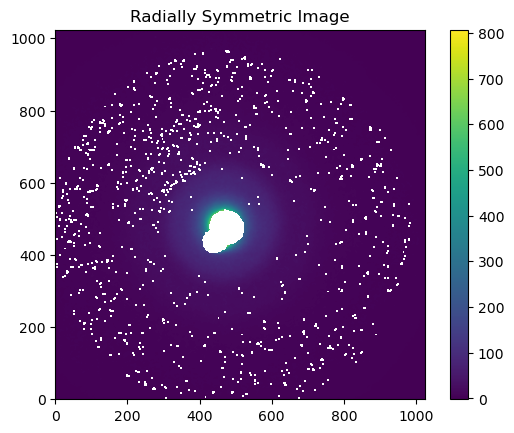

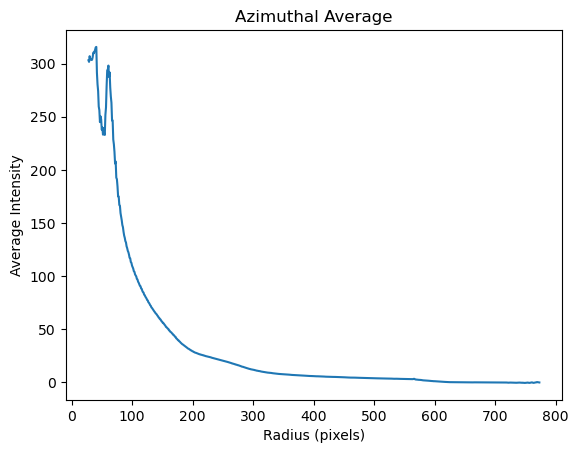

In [32]:
azi_data = []

for i in range(len(stage_ave)):
    azi = azimuthal_average(stage_ave[i], center)
    azi_data.append(azi)

azi_data = np.array(azi_data)

# Plot the results
plt.figure()
plt.imshow(stage_ave[0], origin='lower', extent=[0, 1024, 0, 1024])
plt.colorbar()
plt.title('Radially Symmetric Image')
plt.figure()
plt.plot(azi_data[0])
plt.title('Azimuthal Average')
plt.xlabel('Radius (pixels)')
plt.ylabel('Average Intensity')
plt.show()

In [33]:
def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=5*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I

def get_azimuthal_average(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = ThreadPool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

X_CENTER = center_ave[0]
Y_CENTER = center_ave[1]
GRID_SIZE = 1024

pointer = np.empty((1024,1024))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        pointer[i,j]=int(np.sqrt((i-X_CENTER)**2+(j-Y_CENTER)**2))
img_r_max = int(min(X_CENTER, Y_CENTER, GRID_SIZE-X_CENTER, GRID_SIZE-Y_CENTER))
x=[];y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    x.append(X_temp)
    y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));
r_max=len(x)

azi_data = get_azimuthal_average(stage_ave, x, y)

max Q index is 464


C:\Users\laure\AppData\Local\Temp\ipykernel_27328\1538666883.py:8: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
C:\Users\laure\AppData\Local\Temp\ipykernel_27328\1538666883.py:11: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)
c:\Users\laure\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Normalize Azimuthal Averages to Baseline

c:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\Coding Lab Notebook\GUED_Analysis\GUED.py:1642: RuntimeWarning: Mean of empty slice
  plt.show()


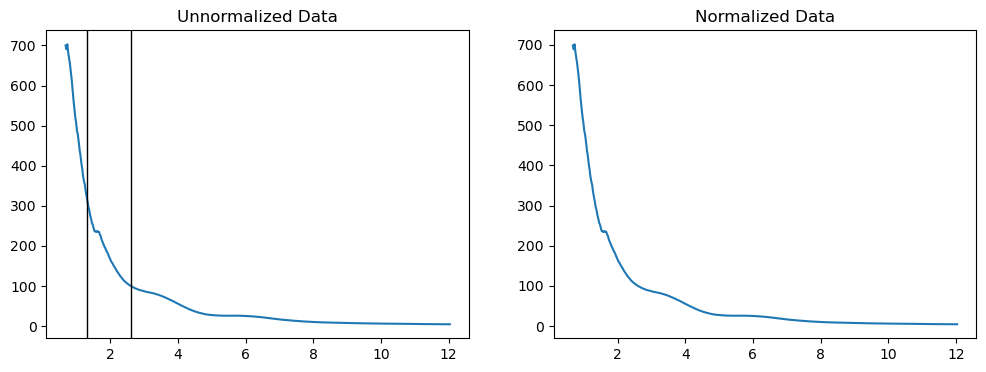

In [34]:
min_val = 50
max_val = 100
norm_data = gued.normalize_to_baseline(azi_data) 

s_cali = 0.026
#posi_0    = 154.405 # The reference T0
#posi_0 = 108.61
posi_0 = 26.9
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(s, azi_data[0])
plt.axvline(x = s[min_val], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = s[max_val], color = 'k', linestyle = '-',linewidth=1);
plt.title("Unnormalized Data")

plt.subplot(1,2,2)
plt.plot(s, norm_data[0])
plt.title("Normalized Data")
plt.show()

## Plotting the Time-Dependent Signal

C:\Users\laure\AppData\Local\Temp\ipykernel_27328\4169235399.py:14: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0
C:\Users\laure\AppData\Local\Temp\ipykernel_27328\4169235399.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


98


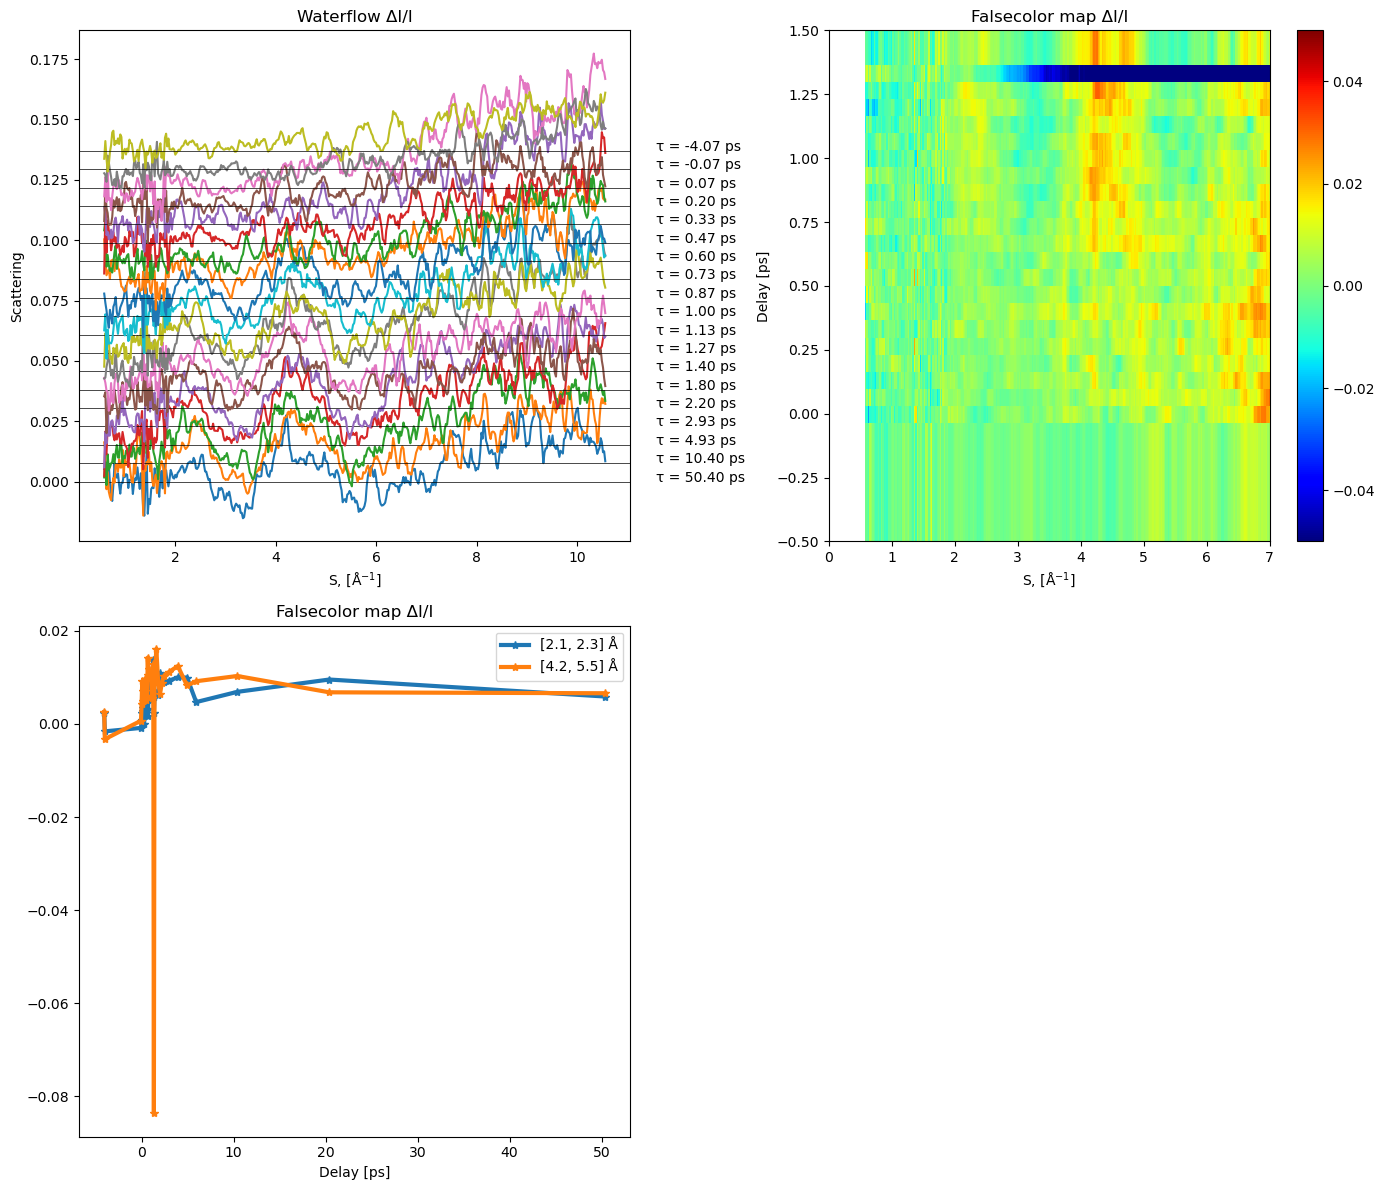

In [35]:
# (3) Plot the figure: Plot the time-dependent signal
angs = '\u00C5'; # angstrom sign
s_cali = 0.0228 # S calibration in experiment
#s_cali = 0.02134
#posi_0    = 154.405 # The reference T0
posi_0 = 108.61
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 3
norm_ref = np.nanmean(norm_data[:N_ref],axis=0);         # Reference signal before T0

dI_I_norm = (norm_data-norm_ref)/norm_ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(14,12))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_norm[stage_len-i-1] + np.nanmax(dI_I_norm)*(i)/15);
        plt.text(s[-1]+1,np.nanmax(dI_I_norm)*(i)/15, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_norm)*(i)/15, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_norm,cmap='jet');
plt.clim(vmin=-0.05, vmax=0.05);
plt.colorbar()
plt.ylim(-0.5, 1.5)
plt.xlim(0, 7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [4.2, 5.5];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = dI_I_norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

## Power Fitting

In [36]:
realtime

array([-4.06666667, -4.        , -0.06666667,  0.        ,  0.06666667,
        0.13333333,  0.2       ,  0.26666667,  0.33333333,  0.4       ,
        0.46666667,  0.53333333,  0.6       ,  0.66666667,  0.73333333,
        0.8       ,  0.86666667,  0.93333333,  1.        ,  1.06666667,
        1.13333333,  1.2       ,  1.26666667,  1.33333333,  1.4       ,
        1.6       ,  1.8       ,  2.        ,  2.2       ,  2.4       ,
        2.93333333,  3.93333333,  4.93333333,  5.93333333, 10.4       ,
       20.4       , 50.4       ])

In [37]:
corrected_dI, baseline2d = gued.power_fit(dI_I_norm, s, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_norm, axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

C:\Users\laure\AppData\Local\Temp\ipykernel_27328\647658921.py:2: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_norm, axis=0)
C:\Users\laure\AppData\Local\Temp\ipykernel_27328\647658921.py:3: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


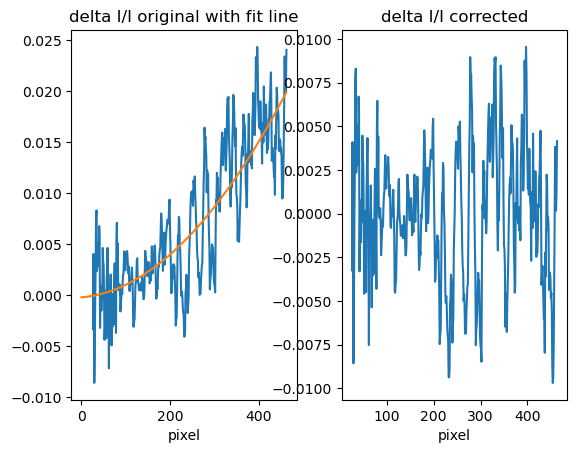

In [38]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(dI_I_norm[0])
plt.plot(baseline2d[0])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.subplot(1,2,2)
plt.plot(corrected_dI[0])
plt.xlabel("pixel")
plt.title("delta I/I corrected")
plt.show()

### Plot with Error Bars

In [39]:
print(corrected_dI.shape)
print(s.shape)
print(uni_stage)

(37, 464)
(464,)
[108.   108.01 108.6  108.61 108.62 108.63 108.64 108.65 108.66 108.67
 108.68 108.69 108.7  108.71 108.72 108.73 108.74 108.75 108.76 108.77
 108.78 108.79 108.8  108.81 108.82 108.85 108.88 108.91 108.94 108.97
 109.05 109.2  109.35 109.5  110.17 111.67 116.17]


26


C:\Users\laure\AppData\Local\Temp\ipykernel_27328\1416765864.py:22: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


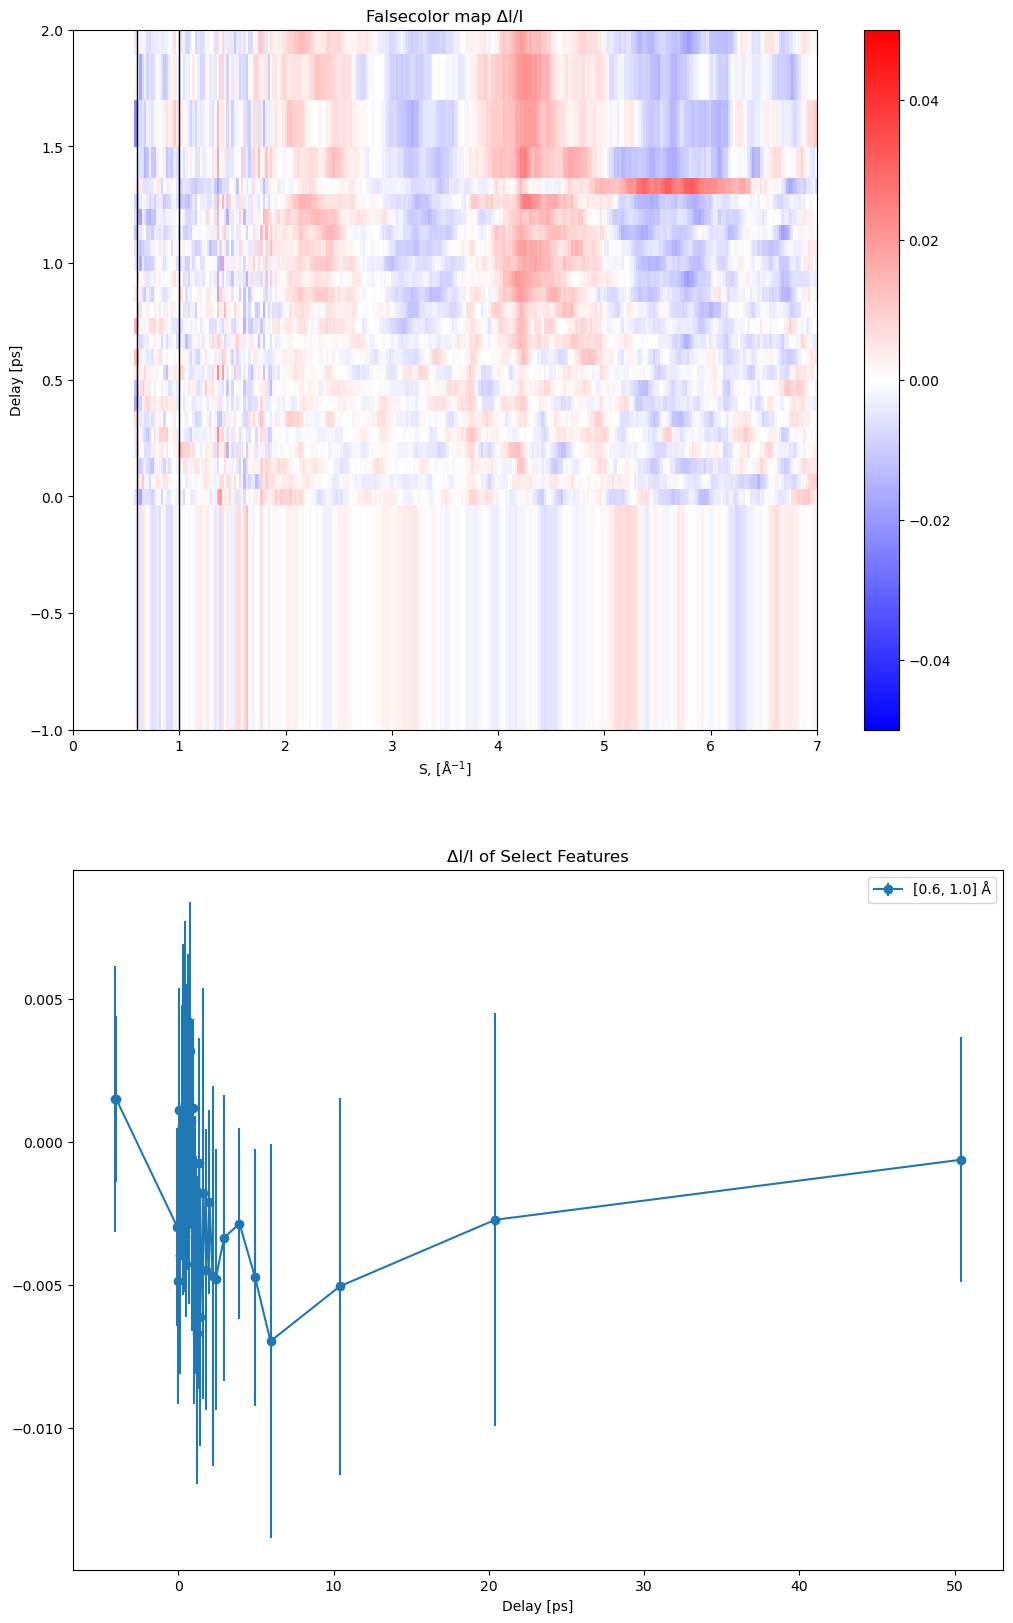

In [40]:
RoI_1 = [0.6, 1.0];
RoI_2 = [4.0, 4.5];
RoI_3 = [2.0, 2.5];
print(round(RoI_1[0]/s_cali))
Inte_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
std_1 = corrected_dI[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].std(axis=1)
Inte_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
std_2 = corrected_dI[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].std(axis=1);
Inte_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].mean(axis=1);
std_3 = corrected_dI[:,round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)].std(axis=1);

plt.figure(figsize=(12,20))
plt.subplot(2,1,1)
plt.pcolor(s,realtime,corrected_dI,cmap='bwr');
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1);
# plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1);
plt.clim(vmin=-0.05, vmax=0.05);
plt.colorbar()
plt.ylim(-1, 2)
#plt.ylim(154.35, 154.6)
plt.xlim(0,7)
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,1,2)
#plt.errorbar(realtime,Inte_1,'-*', yerr=std_1, linewidth=3, label=str(RoI_1)+' '+angs);
#plt.errorbar(realtime,Inte_2,'-*', yerr=std_2, linewidth=3, label=str(RoI_2)+' '+angs);
plt.errorbar(realtime,Inte_1, yerr=std_1,  fmt='-o',  label=str(RoI_1)+' '+angs);
# plt.errorbar(realtime,Inte_2, yerr=std_2,  fmt='-o', label=str(RoI_2)+' '+angs);
# plt.errorbar(realtime,Inte_3, yerr=std_3,  fmt='-o', label=str(RoI_2)+' '+angs);
#plt.xlim(-0.5, 2)
plt.legend()
plt.xlabel('Integrated Yield [arb.]');plt.xlabel('Delay [ps]');plt.title('ΔI/I of Select Features')

plt.show()

In [31]:
time1 =realtime
t0_1= Inte_2-Inte_1+Inte_3
t0_2 = Inte_2
data1 = corrected_dI
s1 = s
raw_data1 = stage_ave
time1.shape

(37,)

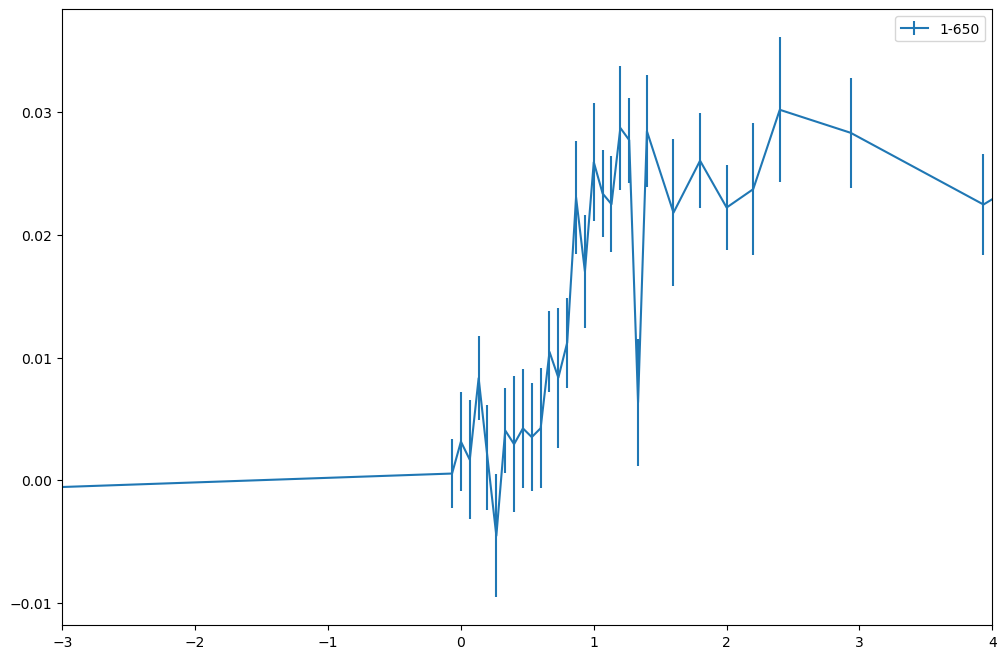

In [32]:
plt.figure(figsize=(12,8))
plt.errorbar(time1, t0_1, yerr=std_1, label="1-650")
#plt.plot(time2, t0_2, label="651-1300")
#plt.plot(time3, t0_3, label="1301-end")
#plt.plot(time4, t0_4, label="1501-end")
plt.xlim(-3,4)
plt.legend()
plt.show()

## Fitting Rise Time

Uses a selected feature in the data to calculate a rise time based on the `scipy.special.erf()`

Fit parameters: 
t_0 = 0.7869  ps +-  0.0456  ps
FWHM =  0.3658 ps 0.1458 ps




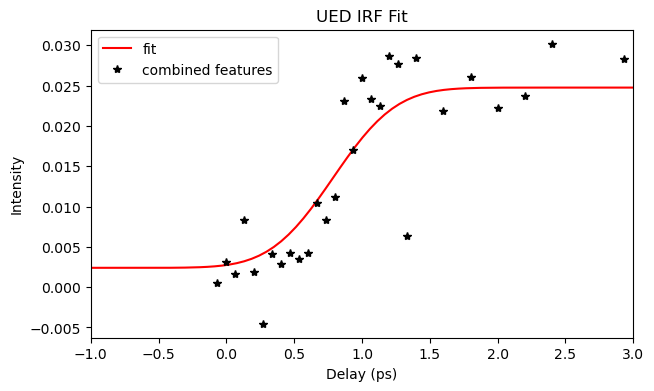

In [33]:
#Optimise

A = 0.04
t0 = 0.0
sigma = 0.5
offset = -0.1
x0 = [A, t0, sigma,offset]
# ## when fitting with an error function
import scipy
def equations(t, A, t0, sigma, offset): #def equations
    fit = A*(scipy.special.erf((t-t0)/(np.sqrt(2)*sigma)))+offset
    return fit

def erf_fit(t, A, t0, sigma, offset):
    fit = A* scipy.special.erf(((t-t0)/(sigma/(np.sqrt(2*np.log(2)))))*np.sqrt(2))+offset
    return fit 

# yo = equations(t, A, t0, sigma, offset) #equations
popt, pcov, id, _, _ = curve_fit(erf_fit, time1[2:], t0_1[2:], p0 = x0, maxfev = 5000000, method='lm',full_output=True)
t_new = np.linspace(realtime[0],realtime[-1],1000)
## error func fit
A, t0, sigma, offset = popt
print("Fit parameters: ")
print("=====================================================")

print("t_0 =", '%1.4f '%(popt[1]),'ps +- ','%1.4f '%np.sqrt(pcov[1,1]),"ps")
print("FWHM = ", '%1.4f'%(popt[2]), 'ps', '%1.4f' %np.sqrt(pcov[2,2]), "ps")

print("\n")
y_new = equations(t_new, *popt)
plt.figure(figsize=(7,4))
# plt.plot(t,yo,color=‘purple’,ls=‘--’)
plt.plot(t_new,y_new,color='red', label="fit")
plt.plot(time1, t0_1,'*',color='black', label="combined features")
plt.xlim(-1,3)
plt.xlabel("Delay (ps)")
plt.ylabel("Intensity")
plt.title("UED IRF Fit")
plt.legend()
plt.show()

## Save Data 

In [43]:
exp_label = "s1"
tag = "fast"
today = date.today()
print(today)

2024-06-12


In [45]:
np.savetxt(f"data_files/dI_corrected_{exp_label}_{tag}_{today}.txt", corrected_dI)
np.savetxt(f"data_files/s_{exp_label}_{tag}_{today}.txt", s)
np.savetxt(f"data_files/realtime_{exp_label}_{tag}_{today}.txt", realtime)
np.savetxt(f"data_files/stage_{exp_label}_{tag}_{today}.txt", uni_stage)
np.savetxt(f"data_files/norm_data_{exp_label}_{tag}_{today}.txt", norm_data)
np.savetxt(f"data_files/norm_ref_{exp_label}_{tag}_{today}.txt", norm_ref)

## Plotting 4 Point Scan

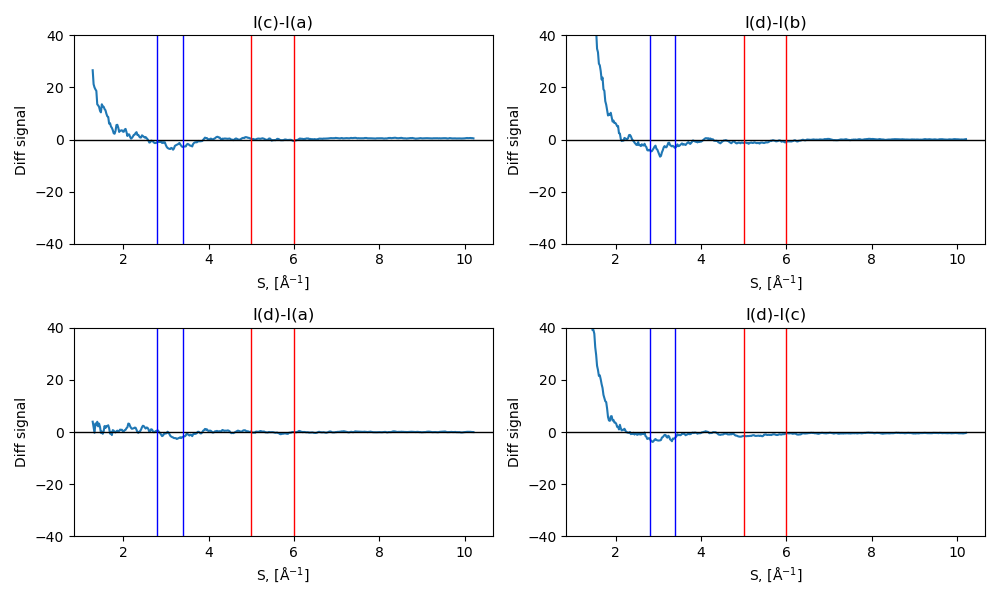

In [ ]:
# (1) A B C D plot
angs = '\u00C5'; # angstrom sign
s_cali = 0.0214 # S calibration in experiment
#posi_0    = 154.405 # The reference T0
posi_0 = 208.955
s = np.arange(0,len(azi_data[0]))*s_cali # The Q axis
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps
ROI1 = [5.0,6.0]; # in Angstrom 
ROI2 = [2.8,3.4]; # in Angstrom

plt.figure(figsize=(10,6)) # Fig plot the different analysis

plt.subplot(2,2,1)
diff_1 = (norm_data[1]-norm_data[3])
plt.plot(s[60:], diff_1[60:]);
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Diff signal');plt.title('I(c)-I(a)');
plt.ylim([-40, 40]);

plt.subplot(2,2,2)
diff_2 = (norm_data[0]-norm_data[2])
plt.plot(s[60:], diff_2[60:]);
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Diff signal')
plt.title('I(d)-I(b)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.subplot(2,2,3)
diff_3 = (norm_data[2]-norm_data[3])
plt.plot(s[60:], diff_3[60:]);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Diff signal');
plt.title('I(d)-I(a)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.subplot(2,2,4)
diff_4 = (norm_data[0]-norm_data[1])
plt.plot(s[60:],diff_4[60:]);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Diff signal');
plt.title('I(d)-I(c)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.tight_layout()
plt.show()

In [ ]:
# (2) Percentage difference signal and scattering ratio plots

if stage_len<=5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 4
norm_ref = np.nanmean(norm_data[-N_ref:],axis=0);             # Reference signal before T0
dI_I_dlys_Norm  = (norm_data-norm_ref)/norm_ref;    # Calculate the percentage difference signal
DeltaI1 = dI_I_dlys_Norm[:,(s<ROI1[1]) & (s>ROI1[0])].mean(axis=1); #
DeltaI2 = dI_I_dlys_Norm[:,(s<ROI2[1]) & (s>ROI2[0])].mean(axis=1); #
Ratio   = norm_data[:,(s<ROI1[1]) & (s>ROI1[0])].mean(axis=1) / norm_data[:,(s<ROI2[1]) & (s>ROI2[0])].mean(axis=1)

/tmp/ipykernel_641558/105493379.py:7: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(norm_data[-N_ref:],axis=0);             # Reference signal before T0


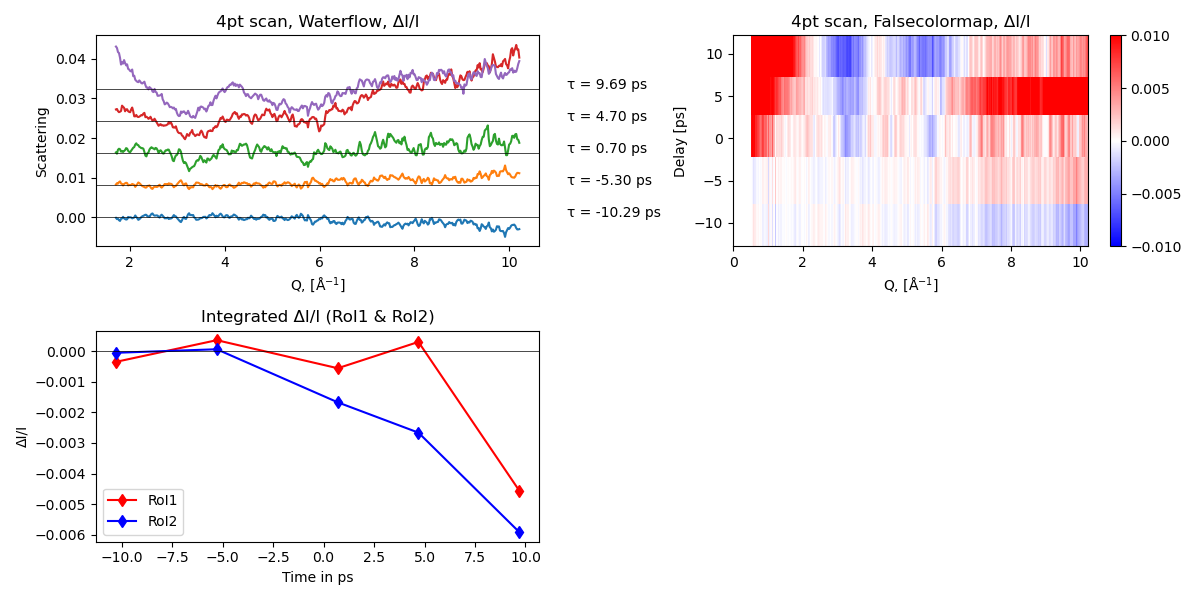

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
for i in range(stage_len):
    plt.plot(s[80:],dI_I_dlys_Norm[stage_len-i-1][80:] + np.nanmax(dI_I_dlys_Norm)*(i)/5);
    plt.text(s[-1]+1,np.nanmax(dI_I_dlys_Norm)*(i)/5, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
    plt.axhline(y = np.nanmax(dI_I_dlys_Norm)*(i)/5, color = 'k', linestyle = '-',linewidth=0.5);
#plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
#plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.xlabel(r'Q, ['+angs+'$^{-1}$]');plt.ylabel('Scattering');plt.title('4pt scan, Waterflow, ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_dlys_Norm,cmap='bwr');plt.clim(vmin=-0.01, vmax=0.01);plt.colorbar()
plt.xlabel(r'Q, ['+angs+'$^{-1}$]');plt.ylabel('Delay [ps]');plt.title('4pt scan, Falsecolormap, ΔI/I')

plt.subplot(2,2,3)
plt.plot(realtime, DeltaI1, '-dr', label='RoI1')
plt.plot(realtime, DeltaI2, '-bd', label='RoI2')
plt.axhline(y=0, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel("Time in ps");plt.ylabel('ΔI/I');plt.title('Integrated ΔI/I (RoI1 & RoI2)');
plt.legend()

# plt.subplot(2,2,4)
# plt.plot(realtime,Ratio,'--dg')
# plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Ratio');plt.title('Integrated I (RoI1 vs RoI2)');

plt.tight_layout()
plt.show()

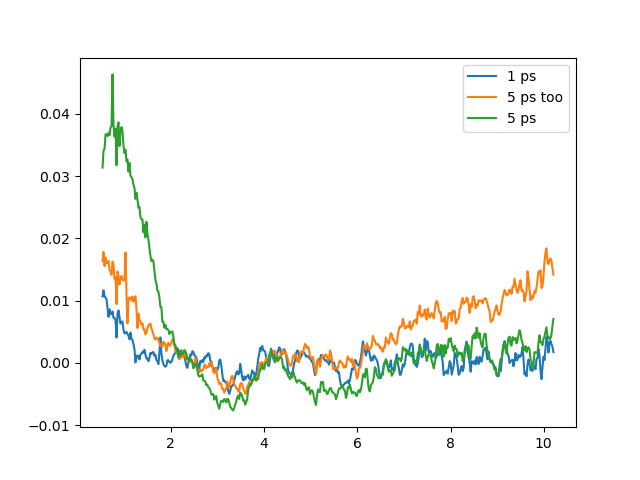

In [ ]:
plt.figure()

plt.plot(s,dI_I_dlys_Norm[2], label="1 ps");
plt.plot(s, dI_I_dlys_Norm[1], label="5 ps too")
plt.plot(s,dI_I_dlys_Norm[0], label="5 ps");
plt.legend()

plt.show()

In [ ]:

corrected_dI, baseline2d = power_fit(dI_I_dlys_Norm , s, return_baseline=True)
dI_I_ave = np.nanmean(dI_I_dlys_Norm , axis=0)
corrected_ave = np.nanmean(corrected_dI, axis=0)
baseline_ave = np.nanmean(baseline2d, axis=0)

/tmp/ipykernel_505790/672403995.py:2: RuntimeWarning: Mean of empty slice
  dI_I_ave = np.nanmean(dI_I_dlys_Norm , axis=0)
/tmp/ipykernel_505790/672403995.py:3: RuntimeWarning: Mean of empty slice
  corrected_ave = np.nanmean(corrected_dI, axis=0)


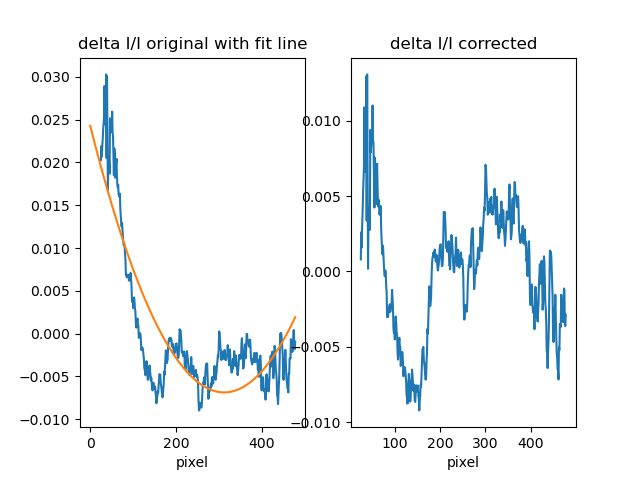

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(dI_I_dlys_Norm [0])
plt.plot(baseline2d[0])
plt.xlabel("pixel")
plt.title("delta I/I original with fit line")

plt.subplot(1,2,2)
plt.plot(corrected_dI[0])
plt.xlabel("pixel")
plt.title("delta I/I corrected")
plt.show()

dI_I_dlys_Norm = corrected_dI